In [1]:
# !ping google.com

# California Topography Data Ingestion

**Dataset**: SRTM (Shuttle Radar Topography Mission) Global - 30m resolution  
**Coverage**: All of California (3 regions merged)  
**Source**: [OpenTopography - SRTM GL1](https://portal.opentopography.org/raster?opentopoID=OTSRTM.082015.4326.1)

**Objective**: 
- Load and merge 3 regional elevation GeoTIFF files
- Validate elevation data quality
- Calculate derived terrain features (slope, aspect)
- Prepare topography data for fire prediction model

**Data Files & Bounding Box Coordinates**:

1. **Northern California**: `Northern-California-rasters_SRTMGL1.tar.gz`
   - xmin: -124.5, ymin: 39.0, xmax: -114.0, ymax: 42.0
   
2. **Central California**: `Central-California-rasters_SRTMGL1.tar.gz`
   - xmin: -124.5, ymin: 36.0, xmax: -114.0, ymax: 39.0
   
3. **Southern California**: `Southern-California-rasters_SRTMGL1.tar.gz`
   - xmin: -124.5, ymin: 32.5, xmax: -114.0, ymax: 36.0

**Data Citation**: NASA Shuttle Radar Topography Mission (SRTM)(2013). Shuttle Radar Topography Mission (SRTM) Global. Distributed by OpenTopography. https://doi.org/10.5069/G9445JDF

## Why Topography Data Matters for Fire Prediction

Terrain characteristics are **critical factors** in wildfire behavior and spread.

### **1. Slope Effects** ⛰️
- **Fire spreads faster uphill**: Flames preheat vegetation upslope
- **Steep slopes = rapid spread**: Fire can move 2-4x faster uphill vs. flat ground
- **Downhill spread is slower**: But still dangerous
- **Critical slopes**: 30-50% grade = extreme fire behavior

### **2. Aspect (Slope Direction)** 🧭
- **South-facing slopes**: More sun exposure → drier vegetation → higher fire risk
- **North-facing slopes**: Cooler, moister, less flammable
- **West-facing slopes**: Afternoon sun + prevailing winds = dangerous
- **East-facing slopes**: Morning sun, generally lower risk

### **3. Elevation** 📏
- **Higher elevations**: Different vegetation types, cooler temperatures
- **Low elevations**: Warmer, drier, often more populated
- **Elevation gradients**: Affect wind patterns and fire spread
- **Mountain valleys**: Can channel winds and fire

### **4. Terrain Complexity** 🗺️
- **Ridges and peaks**: Create wind turbulence, unpredictable fire behavior
- **Canyons**: Channel winds, create "chimney effect" for fires
- **Saddles**: Low points between peaks where fires can cross ridges
- **Rugged terrain**: Harder for firefighters to access

### **5. Fire Behavior Modeling** 🔥
- **Rate of spread**: Slope is a key input to fire spread models
- **Flame length**: Increases dramatically on slopes
- **Spotting distance**: Terrain affects ember transport
- **Containment difficulty**: Steep terrain = harder to fight fires

### **Key Insight for ML:**
The January 2025 Palisades fire spread rapidly through steep canyons in the Santa Monica Mountains. The Eaton fire in Altadena burned upslope through foothill communities. By incorporating slope, aspect, and elevation into our model, we can predict which areas face the highest risk based on terrain characteristics—especially steep south-facing slopes in dry conditions.

In [2]:
# Import libraries
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 1. Load Elevation Data

In [3]:
# Data directory
data_dir = Path('../data/raw/topography/')

# Find all GeoTIFF files
tif_files = list(data_dir.glob('*.tif'))

print("Found elevation files:")
print("=" * 60)
for f in tif_files:
    size_mb = f.stat().st_size / (1024 * 1024)
    print(f"  {f.name}: {size_mb:.1f} MB")

print(f"\nTotal files: {len(tif_files)}")

Found elevation files:
  output_SRTMGL1.tif: 229.1 MB

Total files: 1


## 2. Inspect Elevation Data

In [4]:
# Load the first (or only) elevation file
if len(tif_files) > 0:
    elevation_file = tif_files[0]
    
    print("=" * 80)
    print(f"INSPECTING: {elevation_file.name}")
    print("=" * 80)
    
    with rasterio.open(elevation_file) as src:
        # Metadata
        print(f"\n📊 Raster Metadata:")
        print(f"   Width: {src.width} pixels")
        print(f"   Height: {src.height} pixels")
        print(f"   Bands: {src.count}")
        print(f"   Data type: {src.dtypes[0]}")
        print(f"   CRS: {src.crs}")
        print(f"   Resolution: {src.res[0]:.6f} degrees (~{src.res[0] * 111:.1f} km)")
        
        # Bounds
        print(f"\n📍 Geographic Bounds:")
        print(f"   West: {src.bounds.left:.4f}°")
        print(f"   East: {src.bounds.right:.4f}°")
        print(f"   South: {src.bounds.bottom:.4f}°")
        print(f"   North: {src.bounds.top:.4f}°")
        
        # Read elevation data
        elevation = src.read(1)
        
        # Handle NoData values
        nodata = src.nodata
        if nodata is not None:
            elevation_valid = elevation[elevation != nodata]
        else:
            elevation_valid = elevation.flatten()
        
        print(f"\n🏔️ Elevation Statistics:")
        print(f"   Min elevation: {np.min(elevation_valid):.1f} m")
        print(f"   Max elevation: {np.max(elevation_valid):.1f} m")
        print(f"   Mean elevation: {np.mean(elevation_valid):.1f} m")
        print(f"   Median elevation: {np.median(elevation_valid):.1f} m")
        print(f"   NoData value: {nodata}")
        
        print("\n" + "=" * 80)
else:
    print("⚠️ No GeoTIFF files found!")

INSPECTING: output_SRTMGL1.tif

📊 Raster Metadata:
   Width: 32400 pixels
   Height: 12600 pixels
   Bands: 1
   Data type: int16
   CRS: EPSG:4326
   Resolution: 0.000278 degrees (~0.0 km)

📍 Geographic Bounds:
   West: -123.0001°
   East: -114.0001°
   South: 32.5001°
   North: 36.0001°

🏔️ Elevation Statistics:
   Min elevation: -90.0 m
   Max elevation: 3499.0 m
   Mean elevation: 486.2 m
   Median elevation: 359.0 m
   NoData value: -32768.0



## 3. Visualize Elevation

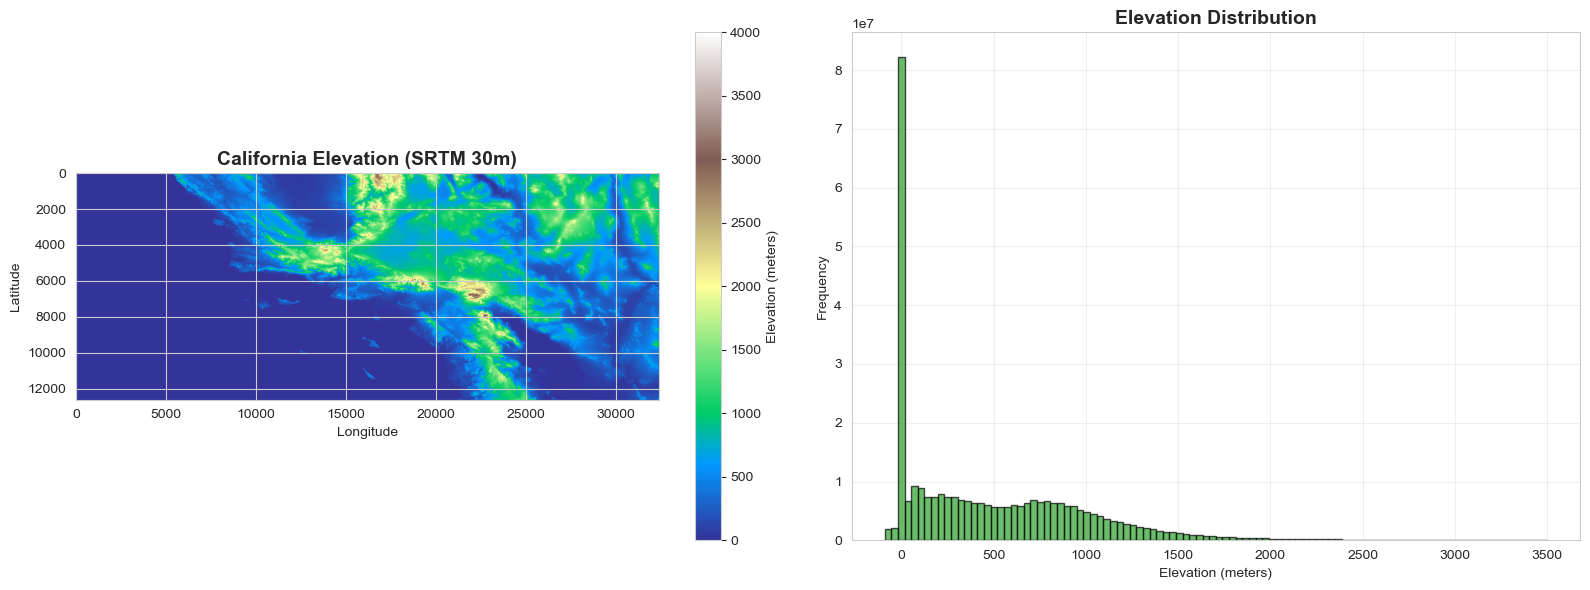

In [5]:
# Visualize elevation data
if len(tif_files) > 0:
    with rasterio.open(elevation_file) as src:
        elevation = src.read(1)
        
        # Create figure
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Elevation map
        im1 = axes[0].imshow(elevation, cmap='terrain', vmin=0, vmax=4000)
        axes[0].set_title('California Elevation (SRTM 30m)', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Longitude')
        axes[0].set_ylabel('Latitude')
        plt.colorbar(im1, ax=axes[0], label='Elevation (meters)')
        
        # Plot 2: Elevation histogram
        elevation_valid = elevation[elevation != src.nodata] if src.nodata else elevation.flatten()
        axes[1].hist(elevation_valid, bins=100, color='#2ca02c', alpha=0.7, edgecolor='black')
        axes[1].set_title('Elevation Distribution', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Elevation (meters)')
        axes[1].set_ylabel('Frequency')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

## 4. Summary for ML Model

In [6]:
print("=" * 80)
print("TOPOGRAPHY DATA SUMMARY FOR ML MODEL")
print("=" * 80)

print(f"\n📊 Dataset Overview:")
print(f"   Source: SRTM Global (Shuttle Radar Topography Mission)")
print(f"   Resolution: 30 meters (~1 arc-second)")
print(f"   Coverage: California (3 regions merged)")
print(f"   Survey date: February 2000")
print(f"   Files: {len(tif_files)} GeoTIFF file(s)")

print(f"\n🏔️ Terrain Features Available:")
print(f"   ✅ Elevation (meters above sea level)")
print(f"   🔄 Slope (to be calculated from elevation)")
print(f"   🔄 Aspect (to be calculated from elevation)")
print(f"   🔄 Terrain roughness (optional)")

print(f"\n🔥 Fire Prediction Relevance:")
print(f"   ✅ Fire spread rate (slope-dependent)")
print(f"   ✅ Vegetation dryness (aspect/sun exposure)")
print(f"   ✅ Wind channeling (terrain features)")
print(f"   ✅ Firefighter access (terrain complexity)")

print(f"\n📝 Next Steps:")
print(f"   1. Calculate slope from elevation (degrees or percent)")
print(f"   2. Calculate aspect from elevation (0-360 degrees)")
print(f"   3. Extract elevation/slope/aspect at fire locations")
print(f"   4. Create county-level terrain summaries")
print(f"   5. Merge with fire, weather, and population data")

print("=" * 80)

TOPOGRAPHY DATA SUMMARY FOR ML MODEL

📊 Dataset Overview:
   Source: SRTM Global (Shuttle Radar Topography Mission)
   Resolution: 30 meters (~1 arc-second)
   Coverage: California (3 regions merged)
   Survey date: February 2000
   Files: 1 GeoTIFF file(s)

🏔️ Terrain Features Available:
   ✅ Elevation (meters above sea level)
   🔄 Slope (to be calculated from elevation)
   🔄 Aspect (to be calculated from elevation)
   🔄 Terrain roughness (optional)

🔥 Fire Prediction Relevance:
   ✅ Fire spread rate (slope-dependent)
   ✅ Vegetation dryness (aspect/sun exposure)
   ✅ Wind channeling (terrain features)
   ✅ Firefighter access (terrain complexity)

📝 Next Steps:
   1. Calculate slope from elevation (degrees or percent)
   2. Calculate aspect from elevation (0-360 degrees)
   3. Extract elevation/slope/aspect at fire locations
   4. Create county-level terrain summaries
   5. Merge with fire, weather, and population data
